# Training

In [9]:
import torch
import scipy.io as sio
import glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.nn.utils import clip_grad_norm_
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop import LpLoss, H1Loss
from neuralop.losses.data_losses import MSELoss
from neuralop.utils import count_model_params
from neuralop.data.transforms.normalizers import UnitGaussianNormalizer
from abc import abstractmethod
import time
import seaborn as sns
import random

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

Training on device: cuda


In [2]:
# --- 1. Find and Load All Data Files ---
data_path = './FNO_Dataset_6_Channel_PT/'
file_paths = glob.glob(f"{data_path}/FNO_dataset_run_*.pt")
file_paths.sort()
random.shuffle(file_paths)

if not file_paths:
    raise FileNotFoundError(f"No .pt files found in {data_path}")

print(f"Found {len(file_paths)} data files.")

# --- 2. Split File Paths into Train and Test ---
train_fraction = 0.6
validation_fraction = 0.2

train_split = int(train_fraction * len(file_paths))
valid_split = int((train_fraction + validation_fraction) * len(file_paths))
train_paths = file_paths[:train_split]
valid_paths = file_paths[train_split:valid_split]
test_paths = file_paths[valid_split:]

with open('test_paths.txt', 'w') as f:
    for path in test_paths:
        f.write(path + '\n')

# --- 3. Load ALL Data into RAM for Normalization ---
# This is the workflow you prefer. It requires
# loading all training data into memory first.

def load_data_from_paths(paths): # <-- Removed data_key
    all_tensors = []
    for p in paths:
        try:
            # Load the .pt file directly as a tensor
            tensor_data = torch.load(p).float() # <-- Changed loading function
            all_tensors.append(tensor_data)
        except Exception as e:
            print(f"Warning: Error loading {p}: {e}")
    # Concatenate all runs along the time dimension (dim=0)
    return torch.cat(all_tensors, dim=0)

print("Loading training data into memory...")
train_data_sequence = load_data_from_paths(train_paths)
print(f"Full training sequence shape: {train_data_sequence.shape}")

print("Loading validation data into memory...")
validation_data_sequence = load_data_from_paths(valid_paths)
print(f"Full validation sequence shape: {validation_data_sequence.shape}")

print("Loading test data into memory...")
test_data_sequence = load_data_from_paths(test_paths)
print(f"Full test sequence shape: {test_data_sequence.shape}")

train_data = train_data_sequence[:, :4, :, :, :]
valid_data = validation_data_sequence[:, :4, :, :, :]
test_data = test_data_sequence[:, :4, :, :, :]

print("Clearing RAM")
del train_data_sequence
del validation_data_sequence
del test_data_sequence

Found 1000 data files.
Loading training data into memory...
Full training sequence shape: torch.Size([24600, 6, 32, 32, 32])
Loading validation data into memory...
Full validation sequence shape: torch.Size([8200, 6, 32, 32, 32])
Loading test data into memory...
Full test sequence shape: torch.Size([8200, 6, 32, 32, 32])
Clearing RAM


In [14]:
# --- 5. Define Simple Dataset Class ---
class TimeSteppingDataset(Dataset):
    """
    A simple dataset that just returns the (t, t+1) pairs
    from a pre-normalized data sequence.
    
    This version is "run-aware" to prevent mixing
    data from different simulation runs.
    """
    def __init__(self, data_sequence, steps_per_run):
        """
        Args:
            data_sequence (torch.Tensor): The giant tensor of all runs
            steps_per_run (int): The number of time steps in EACH run
                                 (e.g., 100)
        """
        self.data = data_sequence
        self.steps_per_run = steps_per_run
        
        # We can't use the last step of *any* run as an input 'x'
        self.valid_pairs_per_run = self.steps_per_run - 1
        
        # Calculate how many runs are in this tensor
        self.num_runs = self.data.shape[0] // self.steps_per_run
        
        if self.data.shape[0] % self.steps_per_run != 0:
            print(f"Warning: Data shape {self.data.shape[0]} is not "
                  f"perfectly divisible by steps_per_run {self.steps_per_run}")

    def __len__(self):
        """
        Returns the total number of *valid* (t, t+1) pairs.
        """
        return self.num_runs * self.valid_pairs_per_run

    def __getitem__(self, idx):
        """
        Gets the N-th *valid* pair, skipping boundaries.
        'idx' will be from 0 to (total_valid_pairs - 1)
        """
        
        # 1. Which run is this pair in?
        # e.g., if valid_pairs_per_run=99, idx=100 -> run_index=1
        run_index = idx // self.valid_pairs_per_run
        
        # 2. What is the time-index *within* that run?
        # e.g., if valid_pairs_per_run=99, idx=100 -> time_index=1
        time_index_in_run = idx % self.valid_pairs_per_run
        
        # 3. What is the *actual* index in the giant data tensor?
        # This calculation skips the boundary indices.
        # e.g., run_index=1, time_index=1 -> (1 * 100) + 1 = 101
        global_start_idx = (run_index * self.steps_per_run) + time_index_in_run
        
        # This will now correctly get (e.g.) data[101] and data[102]
        # and will *never* ask for (data[99], data[100])
        x = self.data[global_start_idx]
        y = self.data[global_start_idx + 1]
        
        return {'x': x, 'y': y[:3]}

In [15]:
# --- 6. Create Datasets and DataLoaders ---

# You must know this value from your data generation
# For example, if each .pt file had 100 time steps:
STEPS_PER_RUN = 101 

# Create the datasets from your NEW normalized tensors
train_dataset = TimeSteppingDataset(train_data, steps_per_run=STEPS_PER_RUN)
valid_dataset = TimeSteppingDataset(valid_data, steps_per_run=STEPS_PER_RUN)
test_dataset = TimeSteppingDataset(test_data, steps_per_run=STEPS_PER_RUN)

# Create the DataLoaders
# Try a small batch size first due to memory
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
# --- 7. Define Model, Optimizer, Loss ---
model = FNO(
    n_modes=(10, 10, 10),
    hidden_channels=32,
    in_channels=4,
    out_channels=3,
    n_layers=4
).to(device) 

print(f"Model has {count_model_params(model)} parameters.")

n_epochs = 1000
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) # Using the lower 1e-4 lr
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
l2loss = LpLoss(d=3, p=2, reduction='mean')
h1loss = H1Loss(d=3, reduction='mean')

# --- 8. Create Trainer (No Processor) ---
trainer = Trainer(model=model, n_epochs=n_epochs,
                  device=device,
                  wandb_log=False,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

Model has 4928739 parameters.


In [17]:
# --- 9. Start Training ---
print("Starting training on full, normalized dataset...")
# Use the shape of one test sample as the key
valid_key = valid_data[0].shape[1]
trainer.train(train_loader=train_loader,
              test_loaders={valid_key: valid_loader},
              optimizer=optimizer,
              scheduler=scheduler,
              training_loss=l2loss,
              eval_losses={'h1': h1loss, 'l2': l2loss},
                save_best=f'{valid_key}_l2',
                save_dir='./checkpoints_4_channels_unscaled/')

Starting training on full, normalized dataset...
Training on 24300 samples
Testing on [8100] samples         on resolutions [32].
Raw outputs of shape torch.Size([64, 3, 32, 32, 32])


/home/prad/personal/CS6886/cs6886-jul-nov-2025-course-project-rephino/sloshing_neural_operator/neuraloperator/neuralop/training/trainer.py:178: UserWarning: training_loss.reduction='mean'. This means that the loss is initialized to average across the batch dim. The Trainer expects losses to sum across the batch dim.
  warnings.warn(
/home/prad/.conda/envs/fno_env/lib/python3.11/site-packages/torch/nn/modules/module.py:1786: UserWarning: FNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)
/home/prad/personal/CS6886/cs6886-jul-nov-2025-course-project-rephino/sloshing_neural_operator/neuraloperator/neuralop/training/trainer.py:536: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


[0] time=157.94, avg_loss=265509.2194, train_err=16978615.8745


/home/prad/personal/CS6886/cs6886-jul-nov-2025-course-project-rephino/sloshing_neural_operator/neuraloperator/neuralop/training/trainer.py:434: UserWarning: eval_loss.reduction='mean'. This means that the loss is initialized to average across the batch dim. The Trainer expects losses to sum across the batch dim.
  warnings.warn(
/home/prad/personal/CS6886/cs6886-jul-nov-2025-course-project-rephino/sloshing_neural_operator/neuraloperator/neuralop/training/trainer.py:581: UserWarning: H1Loss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  val_loss = loss(out, **sample)


Eval: 32_h1=91149.4844, 32_l2=78522.1797
[Rank 0]: saved training state to ./checkpoints_4_channels_unscaled/
[1] time=160.93, avg_loss=103124.1000, train_err=6594514.8142
Eval: 32_h1=152263.6406, 32_l2=152296.1406
[2] time=161.91, avg_loss=83144.5640, train_err=5316876.0651
Eval: 32_h1=110578.9531, 32_l2=111077.3359
[3] time=162.39, avg_loss=80798.7310, train_err=5166866.2220
Eval: 32_h1=49485.6758, 32_l2=47663.0469
[Rank 0]: saved training state to ./checkpoints_4_channels_unscaled/
[4] time=161.85, avg_loss=57747.0008, train_err=3692768.7327
Eval: 32_h1=59427.2578, 32_l2=56332.3984
[5] time=161.22, avg_loss=64610.4811, train_err=4131670.2374
Eval: 32_h1=83986.6719, 32_l2=82986.7734
[6] time=161.85, avg_loss=55483.4392, train_err=3548019.9283
Eval: 32_h1=68997.0312, 32_l2=69368.2109
[7] time=161.90, avg_loss=54404.6308, train_err=3479032.9695
Eval: 32_h1=74919.9531, 32_l2=74424.5234
[8] time=161.32, avg_loss=49899.2308, train_err=3190924.4958
Eval: 32_h1=17692.4531, 32_l2=14725.5410


KeyboardInterrupt: 

# Testing

In [ ]:
# Get one batch from the test loader
for batch in test_loader:
    x = batch['x'].to(device)         # Input tensor
    y = batch['y'].to(device)         # Target tensor
    break  # Only take the first batch

In [ ]:
x_sample = x[31].unsqueeze(0)  # shape: [1, 4, X, Y, Z]
y_sample = y[31].unsqueeze(0)  # shape: [1, 3, X, Y, Z]

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(x_sample)

In [ ]:
z_index = 16
true_slice = y_sample[0, :, :, :, z_index].cpu()
pred_slice = y_pred[0, :, :, :, z_index].cpu()
error_slice = torch.abs(true_slice - pred_slice)

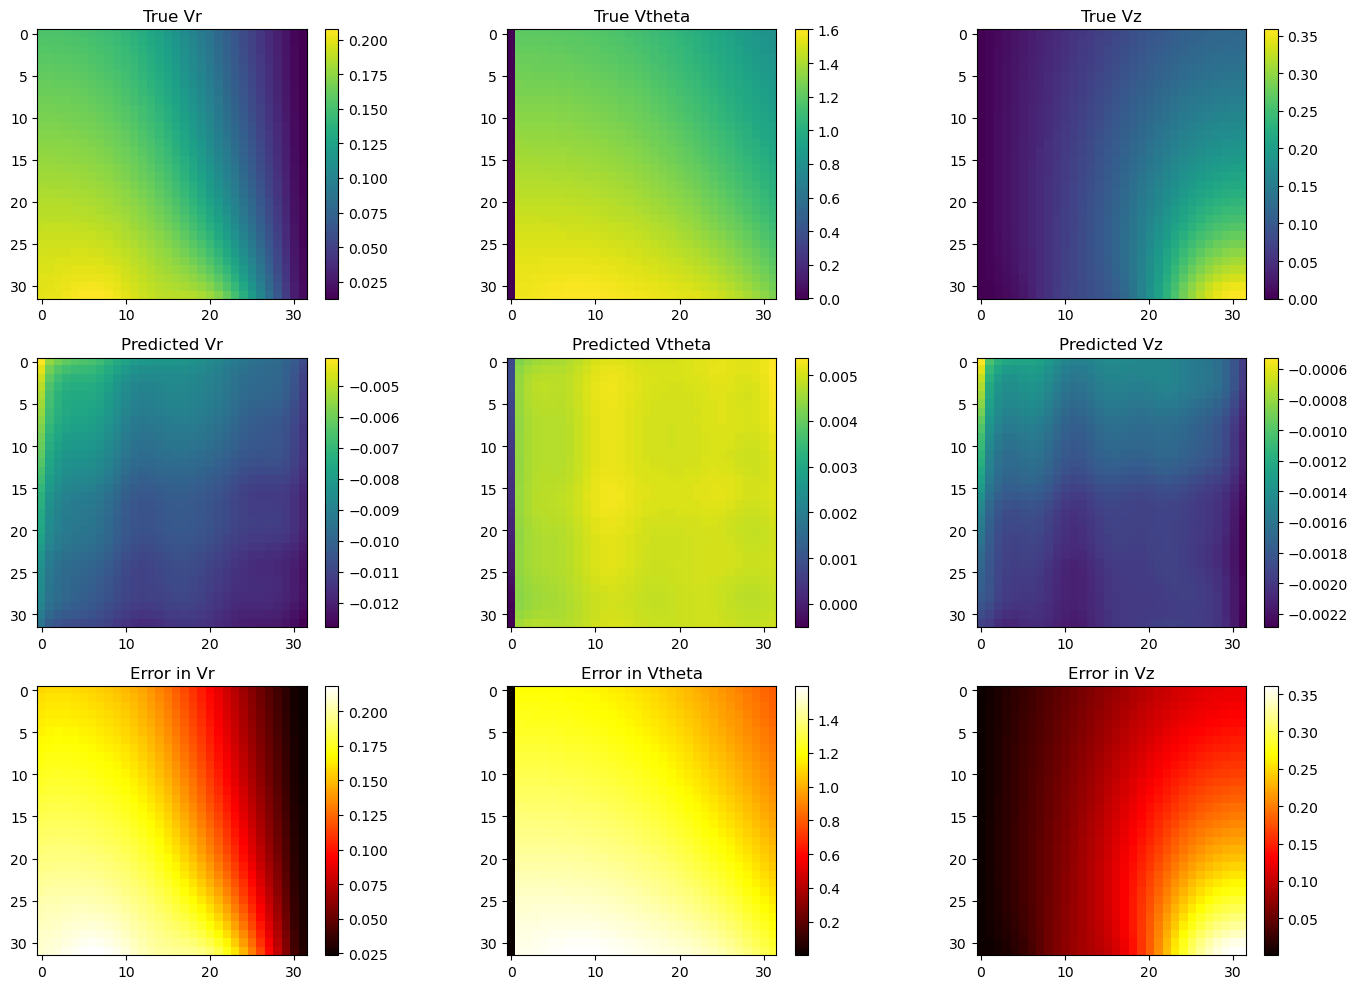

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
components = ['Vr', 'Vtheta', 'Vz']

for i in range(3):
    # True field
    im0 = axs[0, i].imshow(true_slice[i], cmap='viridis')
    axs[0, i].set_title(f"True {components[i]}")
    plt.colorbar(im0, ax=axs[0, i], fraction=0.046, pad=0.04)

    # Predicted field
    im1 = axs[1, i].imshow(pred_slice[i], cmap='viridis')
    axs[1, i].set_title(f"Predicted {components[i]}")
    plt.colorbar(im1, ax=axs[1, i], fraction=0.046, pad=0.04)

    # Error map
    im2 = axs[2, i].imshow(error_slice[i], cmap='hot')
    axs[2, i].set_title(f"Error in {components[i]}")
    plt.colorbar(im2, ax=axs[2, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()